In [13]:
from default_globals import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import romb
from tqdm import tqdm
from redshift_utils import *
from scipy.interpolate import interp1d
from utils import make_nice_plots
import h5py
from scipy import stats
import pandas as pd

make_nice_plots()

COLORS = ['orangered', 'navy', 'teal', 'goldenrod', 'hotpink', 'indigo', 'crimson']


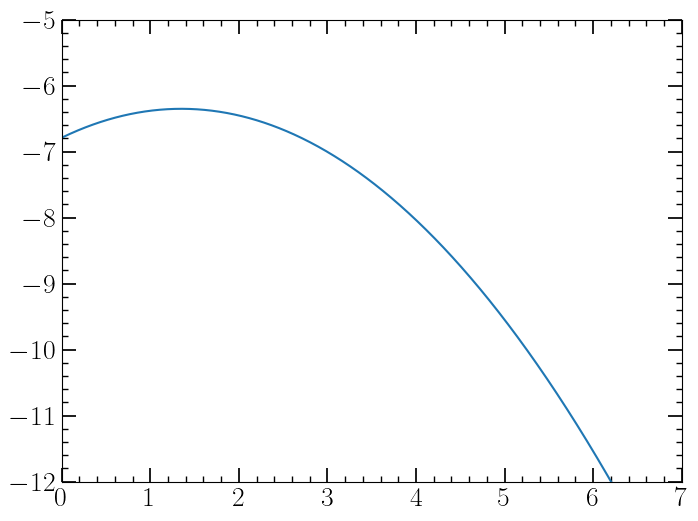

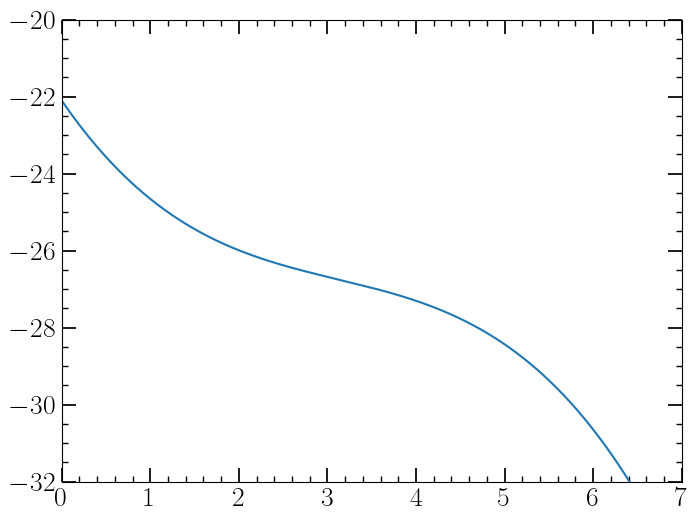

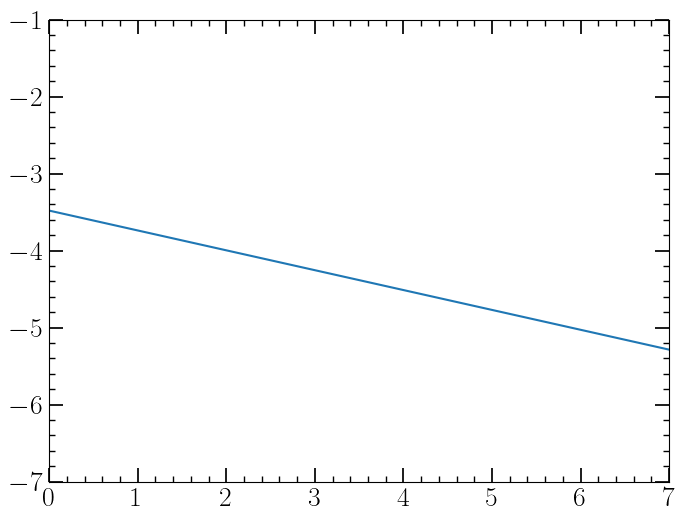

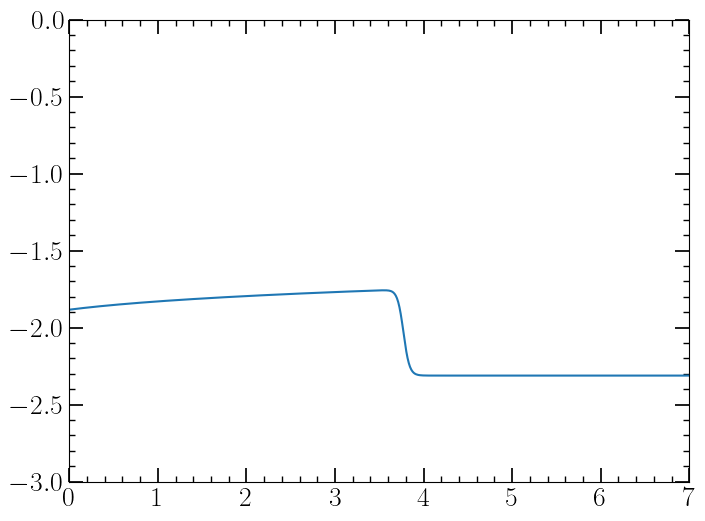

In [14]:
from scipy.special import chebyt

COEFFICIENTS = {
    0: np.array([
        [-7.798, +0.145, -0.157],  # c0,0
        [ 1.128, +0.085, -0.081],  # c0,1
        [-0.120, +0.005, -0.006],  # c0,2
    ]),
    
    1: np.array([
        [-17.163, +0.219, -0.226],   # c1,0
        [ -5.512, +0.127, -0.124],   # c1,1
        [  0.593, +0.011, -0.010],   # c1,2
        [ -0.024, +0.00035, -0.00039], # c1,3
    ]),
    
    2: np.array([
        [ -3.223, +0.127, -0.121],   # c2,0
        [ -0.258, +0.047, -0.051],   # c2,1
    ]),
    
    3: np.array([
        [ -2.312, +0.034, -0.032],   # c3,0
        [  0.559, +0.049, -0.045],   # c3,1
        [  3.773, +0.017, -0.016],   # c3,2
        [141.884, +31.521, -3.832],  # c3,3
        [ -0.171, +0.101, -0.116],   # c3,4
    ])
}


# def QLF(M, phi_star, M_star, alpha, beta):
#     """
#     M: absolute magnitude
#     phi_star: amplitude
#     M_star: break magnitude
#     alpha: bright-end slope
#     beta: faint-end slope
#     """
#     return phi_star / (10**(0.4 * (alpha + 1) * (M - M_star)) + 10**(0.4 * (beta + 1) * (M - M_star)))


def F(i, z):
    z = np.atleast_1d(z)
    x = 1 + z
    ci = COEFFICIENTS[i][:,0]
    
    if i != 3:
        Fi_x = np.zeros_like(z)
        for j, cij in enumerate(ci):
            Fi_x += cij * chebyt(j)(x)
        return Fi_x
    
    else:
        c30, c31, c32, c33, c34 = ci
        zeta = np.log10( x / (1 + c32) )
        return c30 + c31 / (10**(c33 * zeta) + 10**(c34 * zeta))


def log10_phi_star_zevo(z):
    return F(0, z)


def M_star_zevo(z):
    return F(1, z)


def alpha_zevo(z):
    return F(2, z)


def beta_zevo(z):
    return F(3, z)


def log10addexp10(a, b):
    return np.maximum(a, b) + np.log10(1 + 10**(-abs(a - b)))


def log10_QLF(M, z):
    """
    M: absolute magnitude
    log10_phi_star: log base 10 of amplitude [mag^-1 cMpc^-3]
    M_star: break magnitude
    alpha: bright-end slope
    beta: faint-end slope
    """
    log10_phi_star = log10_phi_star_zevo(z)
    M_star = M_star_zevo(z)
    alpha = alpha_zevo(z)
    beta = beta_zevo(z)

    term1 = 0.4 * (alpha + 1) * (M - M_star)
    term2 = 0.4 * (beta + 1) * (M - M_star)
    return log10_phi_star - log10addexp10(term1, term2)


def L2M(log10_Lbol):
    """
    Convert bolometric luminosity to absolute magnitude. We use the magnitude-dependent bolometric correction function (Eq. 9) of Runnoe et al. (2012).
    """
    log10_Liso = log10_Lbol - np.log10(0.75)  # Viewing angle correction
    log10_L1450 = (log10_Liso - 4.74) / 0.91
    L0 = 3.0128e28  # J/s
    return -2.5 * (log10_L1450 - np.log10(L0))
    

# print(L2M(45.5 - 7))

# z_eval = 0.72 # 0.31#
# plt.figure()
# # plt.plot(np.linspace(-30, 0, 1000), np.log10( QLF(np.linspace(-30, 0, 1000), phi_star=10**(-5.72), M_star=-21.30, alpha=-2.74, beta=-1.07) ), label='In bin')
# plt.plot(np.linspace(-30, 0, 1000), np.log10( QLF(np.linspace(-30, 0, 1000), phi_star=10**(-6.57), M_star=-24.21, alpha=-3.55, beta=-1.89) ), label='In bin')
# plt.plot(np.linspace(-30, 0, 1000), log10_QLF(np.linspace(-30, 0, 1000), z=z_eval), label='All z')
# plt.legend()
# plt.show()

z_ax = np.linspace(0, 7, 1000)
plt.figure(figsize=(8,6))
plt.plot(z_ax, log10_phi_star_zevo(z_ax))
plt.xlim(0, 7)
plt.ylim(-12, -5)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(z_ax, M_star_zevo(z_ax))
plt.xlim(0, 7)
plt.ylim(-32, -20)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(z_ax, alpha_zevo(z_ax))
plt.xlim(0, 7)
plt.ylim(-7, -1)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(z_ax, beta_zevo(z_ax))
plt.xlim(0, 7)
plt.ylim(-3, 0)
plt.show()


1025it [00:01, 518.65it/s]
1025it [00:01, 521.77it/s]
1025it [00:01, 523.01it/s]
1025it [00:01, 519.45it/s]
1025it [00:01, 520.28it/s]


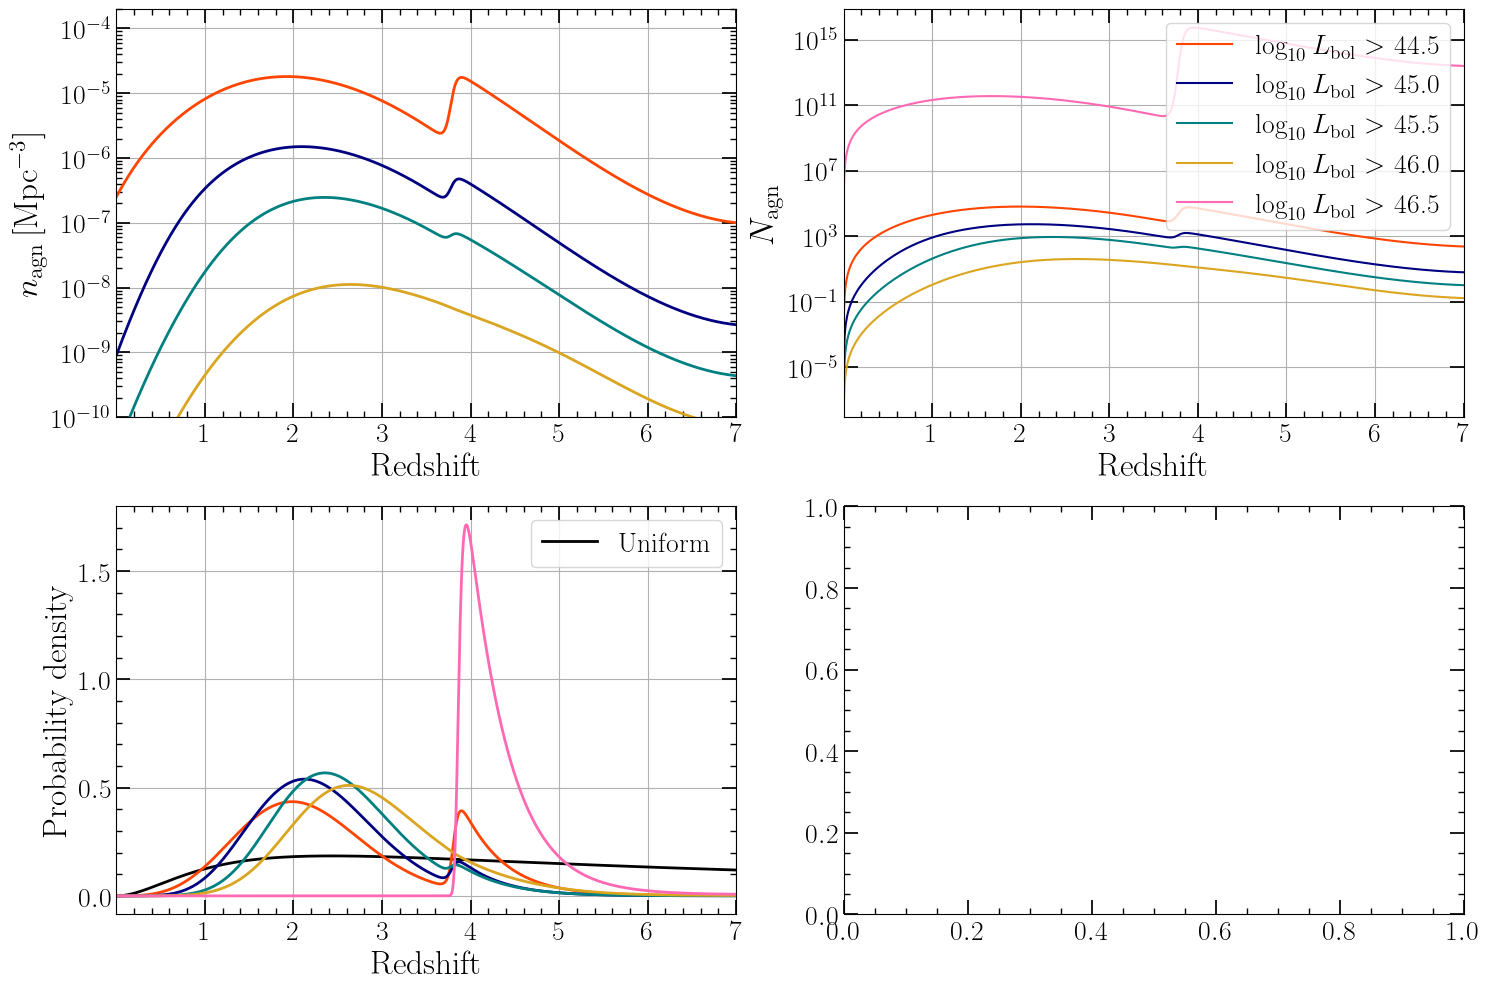

In [15]:
AGN_DIST_DIR = '/home/lucas/Documents/PhD/darksirenpop/agn_distribution'

# from astropy.cosmology import Planck18 as COSMO
m_threshes = [-21, -24, -25.5, -27, 0]
L_threshes = [44.5, 45.0, 45.5, 46.0, 46.5]
sums_of_posteriors = [1, 1, 1, 1, 1]  # [SoP45_0, SoP45_5, SoP46_0, SoP46_5]

zmin = 1e-4
zmax = 7
redshift_bin_edges = np.linspace(zmin, zmax, 1024+2)
redshift_bin_centers = (redshift_bin_edges + np.roll(redshift_bin_edges, shift=1))[1:] / 2

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))

ax1.semilogy()
ax1.set_xlim(zmin, zmax)
ax1.set_ylim(1e-10, 2e-4)
ax1.set_xlabel('Redshift')
ax1.set_ylabel(r'$n_{\rm agn} \, [\mathrm{Mpc^{-3}}]$')
ax1.grid()

ax2.grid()
ax2.semilogy()
ax2.set_xlim(zmin, zmax)
ax2.set_xlabel('Redshift')
ax2.set_ylabel(r'$N_{\rm agn}$')

ax3.grid()
ax3.set_xlim(zmin, zmax)
ax3.set_xlabel('Redshift')
ax3.set_ylabel('Probability density')
ax3.plot(redshift_bin_centers, uniform_comoving_prior(redshift_bin_centers) / romb(uniform_comoving_prior(redshift_bin_centers), dx=np.diff(redshift_bin_centers)[0]), label='Uniform', color='black', linewidth=2)

for i, (L_thresh, sum_of_posteriors) in enumerate(zip(L_threshes, sums_of_posteriors)):

    # Step 1: Get number densities by integrating QLF over magnitude
    # magthresh = L2M(L_thresh - 7)
    magthresh = m_threshes[i]
    mag_integrate_axis = np.linspace(-100, magthresh, int(1024)+1)
    n_of_z = lambda z: romb(10**log10_QLF(mag_integrate_axis[:,np.newaxis], z=z[np.newaxis,:]), dx=np.diff(mag_integrate_axis)[0], axis=0)
    numdenses = n_of_z(redshift_bin_edges).flatten()
    ax1.plot(redshift_bin_edges, numdenses, color=COLORS[i], linewidth=2)

    # Step 2: Get redshift distribution by integrating QLF in redshift bins
    n_agn_in_zbin = np.zeros_like(redshift_bin_centers)
    for j, redshift_bin_center in tqdm( enumerate(redshift_bin_centers) ):
        zlow, zhigh = redshift_bin_edges[j], redshift_bin_edges[j+1]
        z_integrate_ax = np.linspace(zlow, zhigh, 128+1)

        numdens_in_bin = n_of_z(z_integrate_ax)
        n_agn_in_zbin[j] = 4 * np.pi * romb(numdens_in_bin * COSMO.differential_comoving_volume(z_integrate_ax).value, dx=np.diff(z_integrate_ax)[0])
    ax2.plot(redshift_bin_centers, n_agn_in_zbin, color=COLORS[i], label=r'$\log_{10} L_{\rm bol} >$ ' + str(L_thresh))

    # Step 3: Get redshift PDFs by normalizing
    agn_redshift_pdf = n_agn_in_zbin / romb(n_agn_in_zbin, dx=np.diff(redshift_bin_centers)[0])
    ax3.plot(redshift_bin_centers, agn_redshift_pdf, color=COLORS[i], linewidth=2)

    # np.save(f'{AGN_DIST_DIR}/agn_redshift_pdf_{L_thresh}', np.array([redshift_bin_centers, agn_redshift_pdf]))

ax2.legend()
ax3.legend()
plt.tight_layout()
plt.show()


In [16]:
VERBOSE = True

AGN_DIST_DIR = '/home/lucas/Documents/PhD/darksirenpop/agn_distribution'

ZMIN = 1e-4  # Some buffer for astropy's lowest possible value
ZMAX = 1.5   # Maximum true redshift for GWs, such that p_rate(z > ZMAX) = 0
AGN_ZMAX = 7.
AGN_COMDIST_MAX = COSMO.comoving_distance(AGN_ZMAX).value

AGN_ZPRIOR = '44.5'

Z_INTEGRAL_AX = np.linspace(ZMIN, ZMAX, int(512)+1)  # Sets the resolution of the redshift prior, should capture all information of AGN posteriors, see Gray et al. 2022, 2023
ASSUME_PERFECT_REDSHIFT = False
AGN_ZERROR = 'quaia'
if AGN_ZERROR == 'quaia':
    quaia_errors = pd.read_csv("/home/lucas/Documents/PhD/Quaia_z15.csv")["redshift_quaia_err"]  # Load into memory and sample later
    

def get_agn_zprior():
    """
    'positive_redshift', 'uniform_comoving_volume', '44.5', '45.0', '45.5', '46.0', '46.5'
    """

    if AGN_ZPRIOR == 'uniform_comoving_volume':
        return lambda z: uniform_comoving_prior(z)
    
    elif str(AGN_ZPRIOR) in ['44.5', '45.0', '45.5', '46.0', '46.5']:
        filename = f'{AGN_DIST_DIR}/agn_redshift_pdf_{AGN_ZPRIOR}.npy'
        if VERBOSE:
            print(f'Loading AGN redshift distribution calculated from QLF from file: {filename}')
        z, n = np.load(filename)
        return interp1d(z, n, bounds_error=False, fill_value=0)
    
    elif AGN_ZPRIOR == 'positive_redshift':  # Equivalent to a uniform-in-redshift prior. Redundant since the Z_INTEGRAL_AX is >0, but this way we enforce a conscious decision on the prior.
        return lambda z: z_cut(-z, zcut=0)
    
    else:
        sys.exit(f'AGN redshift prior not recognized: {AGN_ZPRIOR}. \nExiting...')


def get_agn_z_posterior_norm_ax(at_least_N=10):
    if AGN_ZERROR == 'quaia':
        smallest_error = np.min(quaia_errors)
    else:
        smallest_error = AGN_ZERROR
    npoints = int(2**np.ceil(np.log2(at_least_N * (AGN_ZMAX - ZMIN) / smallest_error)))  # Enforces at least N points within 1 sigma in normalization of AGN posteriors
    return np.linspace(ZMIN, AGN_ZMAX, npoints + 1)


AGN_ZPRIOR_FUNCTION = get_agn_zprior()

if not ASSUME_PERFECT_REDSHIFT:
    AGN_POSTERIOR_NORM_AX = get_agn_z_posterior_norm_ax()


def compute_and_save_posteriors_hdf5(filename, all_agn_z, all_agn_z_err):
    '''
    AGN redshift posteriors are modelled as truncnorms on [0, inf) with a uniform-in-comoving-volume redshift prior.
    The posteriors are normalized on agn_posterior_norm_ax, which goes up to AGN_ZMAX.
    The posteriors are then evaluated on Z_INTEGRAL_AX, which is what is necessary for the crossmatch.
    '''

    maxdiff = np.max(np.diff(AGN_POSTERIOR_NORM_AX))
    thresh = np.min(all_agn_z_err) / 10
    assert maxdiff < thresh, f'AGN normalization array is too coarse to capture AGN distribution fully. Got {maxdiff:.3e}, need {thresh:.3e}.'

    n_agn = len(all_agn_z)
    n_z = len(Z_INTEGRAL_AX)  # Only need to save the posterior evaluated at this axis
    chunk_size = int(1e6 / n_z)
    dx = np.diff(AGN_POSTERIOR_NORM_AX)[0]  # For romb integration on linear axis
    with h5py.File(filename, "w") as f:
        dset = f.create_dataset("agn_redshift_posteriors", shape=(n_agn, n_z), dtype=np.float64)

        if VERBOSE:
            iterchunks = tqdm( range(0, n_agn, chunk_size) )
        else:
            iterchunks = range(0, n_agn, chunk_size)

        for start in iterchunks:
            end = min(start + chunk_size, n_agn)

            z_chunk = all_agn_z[start:end]
            zerr_chunk = all_agn_z_err[start:end]

            likelihood = lambda z: stats.truncnorm.pdf(
                z,
                a=(ZMIN - z_chunk[:, None]) / zerr_chunk[:, None],
                b=(np.inf - z_chunk[:, None]) / zerr_chunk[:, None],
                loc=z_chunk[:, None],
                scale=zerr_chunk[:, None]
            )

            agn_posteriors_unnorm = lambda z: likelihood(z) * z_cut(z, zcut=AGN_ZMAX) * AGN_ZPRIOR_FUNCTION(z)
            z_norms = romb(agn_posteriors_unnorm(AGN_POSTERIOR_NORM_AX), dx=dx)
            posteriors = agn_posteriors_unnorm(Z_INTEGRAL_AX) / z_norms[:, None]  # Save the posterior evaluated at the relevant axis

            dset[start:end, :] = posteriors
    if VERBOSE:
        print(f"All AGN posteriors written to {filename}")
    return


Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_44.5.npy


In [17]:
quaia_errors = pd.read_csv("/home/lucas/Documents/PhD/Quaia_z15.csv")["redshift_quaia_err"]
quaia_redshift = pd.read_csv("/home/lucas/Documents/PhD/Quaia_z15.csv")["redshift_quaia"]
print(np.mean(quaia_errors), np.median(quaia_errors))
print(np.mean(quaia_errors / quaia_redshift), np.median(quaia_errors / quaia_redshift))

0.15542349592601193 0.10620452251911165
0.17179086641182903 0.13639619667973074


Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_44.5.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_45.0.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_45.5.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_46.0.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_46.5.npy


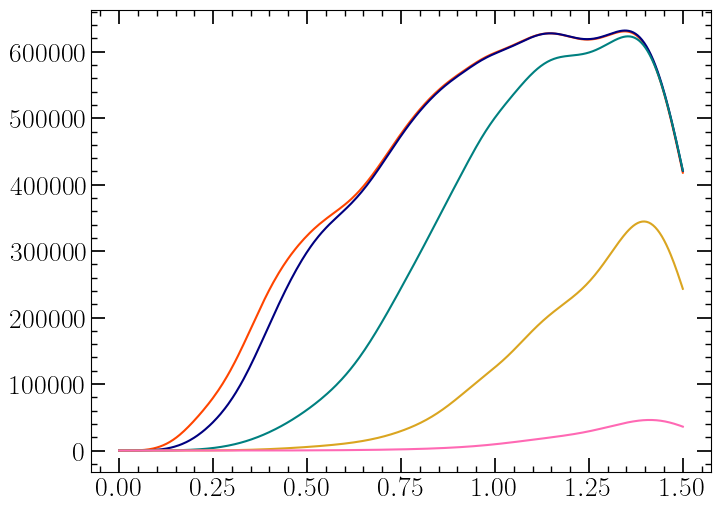

In [18]:
CATALOG_PATH = "/home/lucas/Documents/PhD/Quaia_z15.csv"

for thresh in L_threshes:
    df = pd.read_csv(CATALOG_PATH)
    cols = ["redshift_quaia", "redshift_quaia_err", "ra", "dec", "b", "loglbol_corr"]
    data = df[cols]
    b              = data["b"].to_numpy()
    loglbol_corr   = data["loglbol_corr"].to_numpy()
    outside_galactic_plane = np.logical_or((b > 10), (b < -10))
    above_lbol_thresh = loglbol_corr >= float(thresh)

    agn_redshift       = data["redshift_quaia"].to_numpy()[outside_galactic_plane & above_lbol_thresh]
    agn_redshift_err   = data["redshift_quaia_err"].to_numpy()[outside_galactic_plane & above_lbol_thresh]

    filename = f'./quaia_testing_{thresh}_QLFPRIOR.hdf5'

    AGN_ZPRIOR = thresh
    AGN_ZPRIOR_FUNCTION = get_agn_zprior()
    # compute_and_save_posteriors_hdf5(filename, agn_redshift, agn_redshift_err)

with h5py.File(f'./quaia_testing_44.5_QLFPRIOR.hdf5', "r") as f:
    agn_posterior_dset = f["agn_redshift_posteriors"][()]
SoP44_5 = np.sum(agn_posterior_dset, axis=0)  

with h5py.File(f'./quaia_testing_45.0_QLFPRIOR.hdf5', "r") as f:
    agn_posterior_dset = f["agn_redshift_posteriors"][()]
SoP45_0 = np.sum(agn_posterior_dset, axis=0)  

with h5py.File(f'./quaia_testing_45.5_QLFPRIOR.hdf5', "r") as f:
    agn_posterior_dset = f["agn_redshift_posteriors"][()]
SoP45_5 = np.sum(agn_posterior_dset, axis=0) 

with h5py.File(f'./quaia_testing_46.0_QLFPRIOR.hdf5', "r") as f:
    agn_posterior_dset = f["agn_redshift_posteriors"][()]
SoP46_0 = np.sum(agn_posterior_dset, axis=0) 

with h5py.File(f'./quaia_testing_46.5_QLFPRIOR.hdf5', "r") as f:
    agn_posterior_dset = f["agn_redshift_posteriors"][()]
SoP46_5 = np.sum(agn_posterior_dset, axis=0) 


plt.figure(figsize=(8,6))
for i, SoP in enumerate([SoP44_5, SoP45_0, SoP45_5, SoP46_0, SoP46_5]):
    plt.plot(Z_INTEGRAL_AX, SoP, color=COLORS[i])
plt.show()


Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_44.5.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_45.0.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_45.5.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_46.0.npy
Loading AGN redshift distribution calculated from QLF from file: /home/lucas/Documents/PhD/darksirenpop/agn_distribution/agn_redshift_pdf_46.5.npy


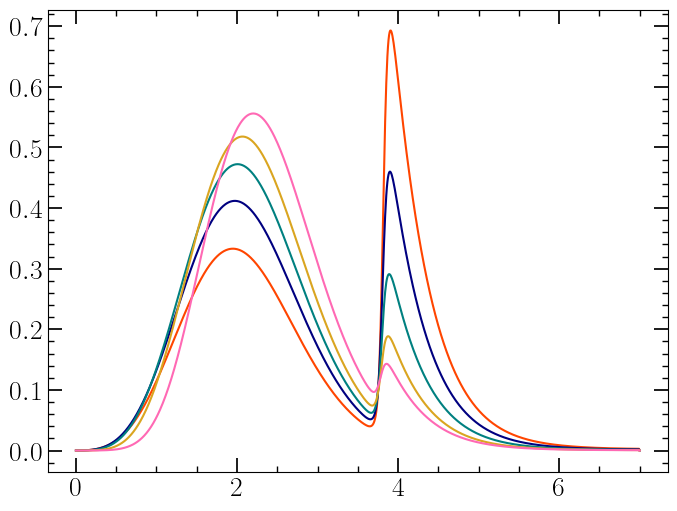

In [19]:
plt.figure(figsize=(8,6))
for i, thresh in enumerate(L_threshes):
    AGN_ZPRIOR = thresh
    AGN_ZPRIOR_FUNCTION = get_agn_zprior()
    plt.plot(np.linspace(1e-4, 7, 1000), AGN_ZPRIOR_FUNCTION(np.linspace(1e-4, 7, 1000)), color=COLORS[i])
plt.show()


1025it [00:01, 515.79it/s]
1025it [00:01, 522.51it/s]
1025it [00:01, 520.41it/s]
1025it [00:01, 522.04it/s]
1025it [00:01, 518.49it/s]


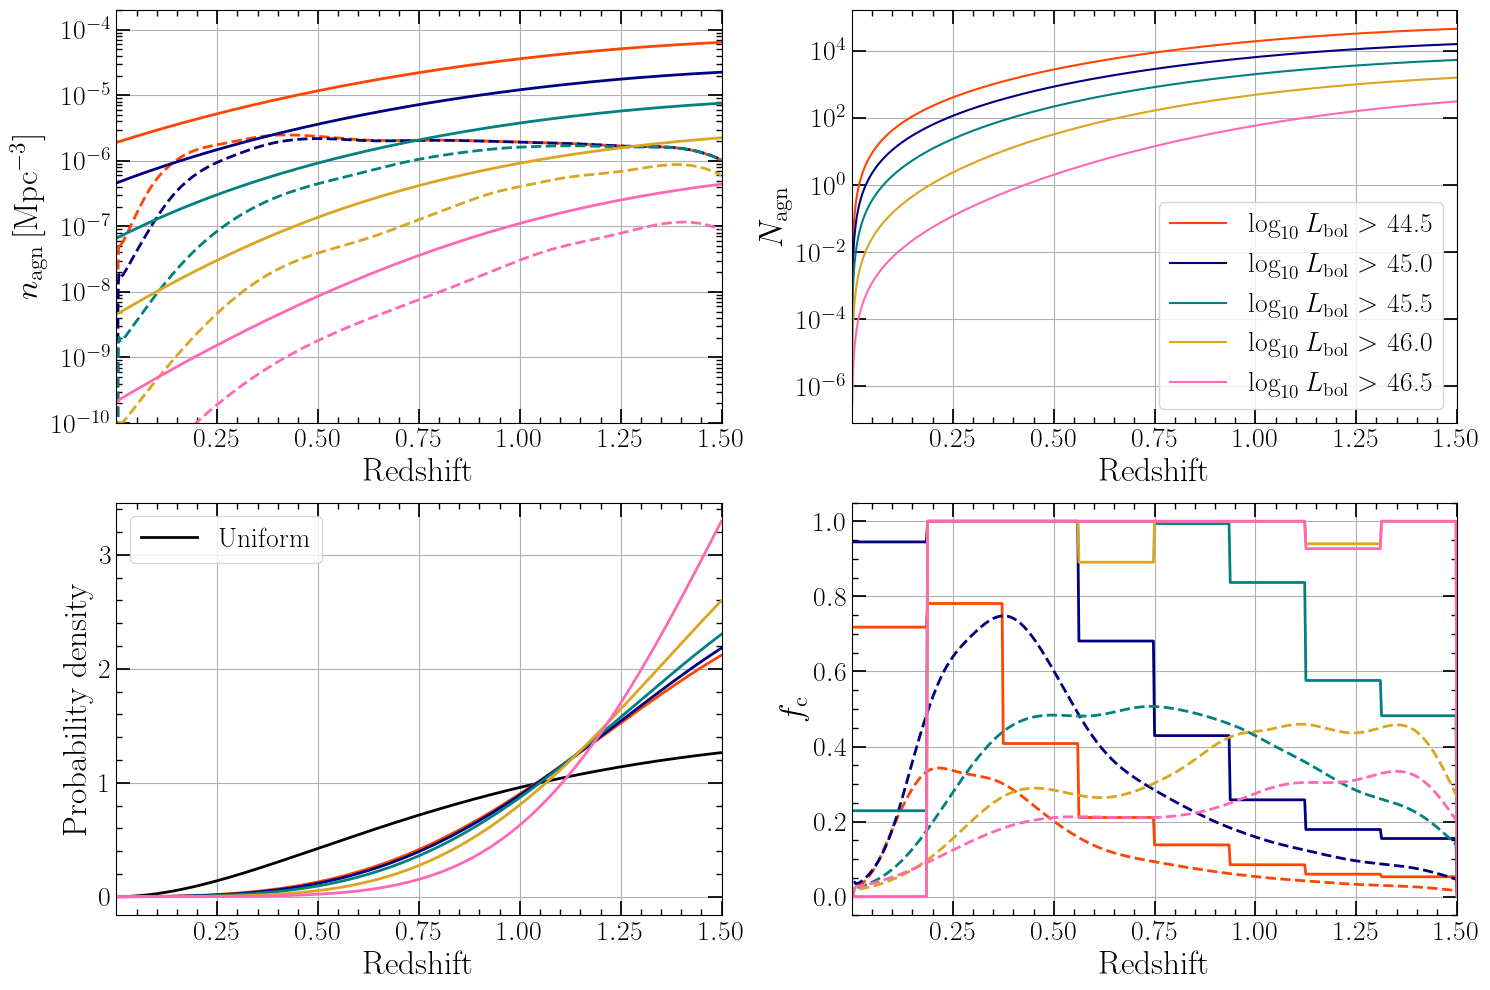

In [ ]:
L_threshes = [44.5, 45.0, 45.5, 46.0, 46.5]
sums_of_posteriors = [SoP44_5, SoP45_0, SoP45_5, SoP46_0, SoP46_5]

zmin = 1e-4
zmax = 1.5
redshift_bin_edges = np.linspace(zmin, zmax, 1024+2)
redshift_bin_centers = (redshift_bin_edges + np.roll(redshift_bin_edges, shift=1))[1:] / 2


def obs_numdens_of_z(z, sum_of_posteriors):
    observed_sky_fraction = 0.86
    n = sum_of_posteriors / (4 * np.pi * COSMO.differential_comoving_volume(Z_INTEGRAL_AX).value) / observed_sky_fraction
    return interp1d(x=Z_INTEGRAL_AX, y=n, bounds_error=False, fill_value=0)(z)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))

ax1.semilogy()
ax1.set_xlim(zmin, zmax)
ax1.set_ylim(1e-10, 2e-4)
ax1.set_xlabel('Redshift')
ax1.set_ylabel(r'$n_{\rm agn} \, [\mathrm{Mpc^{-3}}]$')
ax1.grid()

ax2.grid()
ax2.semilogy()
ax2.set_xlim(zmin, zmax)
ax2.set_xlabel('Redshift')
ax2.set_ylabel(r'$N_{\rm agn}$')

ax3.grid()
ax3.set_xlim(zmin, zmax)
ax3.set_xlabel('Redshift')
ax3.set_ylabel('Probability density')
ax3.plot(redshift_bin_centers, uniform_comoving_prior(redshift_bin_centers) / romb(uniform_comoving_prior(redshift_bin_centers), dx=np.diff(redshift_bin_centers)[0]), label='Uniform', color='black', linewidth=2)

AGN_ZCUT = 1.5
THRESHOLD_MAP = {"46.5": 0, "46.0": 1, "45.5": 2, "45.0": 3, "44.5": 4}
V25_zedges = np.array([0.0000, 0.1875, 0.3750, 0.5625, 0.7500, 0.9375, 1.1250, 1.3125, AGN_ZCUT, AGN_ZMAX])
QUAIA_C_VALS = np.array([
                    [0.000, 0.000, 0.229, 0.945, 0.718],
                    [1.000, 1.000, 1.000, 1.000, 0.781],
                    [1.000, 1.000, 1.000, 1.000, 0.408],
                    [1.000, 0.891, 1.000, 0.681, 0.211],
                    [1.000, 1.000, 0.994, 0.429, 0.138],
                    [1.000, 1.000, 0.837, 0.258, 0.085],
                    [0.927, 0.940, 0.576, 0.179, 0.060],
                    [1.000, 1.000, 0.482, 0.155, 0.053],
                    [0., 0., 0., 0., 0.]])
def redshift_completeness(z, completeness_zedges, completeness_zvals):
    bin_idx = np.digitize(z, completeness_zedges) - 1
    bin_idx[bin_idx == len(completeness_zvals)] = len(completeness_zvals) - 1
    return completeness_zvals[bin_idx.astype(np.int32)]

ax4.grid()
ax4.set_xlim(zmin, zmax)
ax4.set_ylabel(r'$f_{\rm c}$')
ax4.set_xlabel('Redshift')

for i, (L_thresh, sum_of_posteriors) in enumerate(zip(L_threshes, sums_of_posteriors)):

    # Step 1: Get number densities by integrating QLF over magnitude
    magthresh = L2M(L_thresh - 7)
    mag_integrate_axis = np.linspace(-100, magthresh, int(1024)+1)
    n_of_z = lambda z: romb(10**log10_QLF(mag_integrate_axis[:,np.newaxis], z=z[np.newaxis,:]), dx=np.diff(mag_integrate_axis)[0], axis=0)
    qlf_numdenses = n_of_z(redshift_bin_centers).flatten()
    obs_numdenses = obs_numdens_of_z(redshift_bin_centers, sum_of_posteriors)
    ax1.plot(redshift_bin_centers, qlf_numdenses, color=COLORS[i], linewidth=2)
    ax1.plot(redshift_bin_centers, obs_numdenses, color=COLORS[i], linewidth=2, linestyle='dashed')

    # Step 2: Get redshift distribution by integrating QLF in redshift bins
    n_agn_in_zbin = np.zeros_like(redshift_bin_centers)
    for j, redshift_bin_center in tqdm( enumerate(redshift_bin_centers) ):
        zlow, zhigh = redshift_bin_edges[j], redshift_bin_edges[j+1]
        z_integrate_ax = np.linspace(zlow, zhigh, 128+1)

        numdens_in_bin = n_of_z(z_integrate_ax)
        n_agn_in_zbin[j] = 4 * np.pi * romb(numdens_in_bin * COSMO.differential_comoving_volume(z_integrate_ax).value, dx=np.diff(z_integrate_ax)[0])
    ax2.plot(redshift_bin_centers, n_agn_in_zbin, color=COLORS[i], label=r'$\log_{10} L_{\rm bol} >$ ' + str(L_thresh))

    # Step 3: Get redshift PDFs by normalizing
    agn_redshift_pdf = n_agn_in_zbin / romb(n_agn_in_zbin, dx=np.diff(redshift_bin_centers)[0])
    ax3.plot(redshift_bin_centers, agn_redshift_pdf, color=COLORS[i], linewidth=2)

    # Step 4: Plot completenesses
    fc_of_z = obs_numdenses / qlf_numdenses
    ax4.plot(redshift_bin_centers, fc_of_z, color=COLORS[i], linewidth=2, linestyle='dashed')
    ax4.plot(Z_INTEGRAL_AX, redshift_completeness(Z_INTEGRAL_AX, V25_zedges, np.array(QUAIA_C_VALS[:, THRESHOLD_MAP[str(L_thresh)]])), linewidth=2, label=f'V25 {L_thresh}', color=COLORS[i])

    # np.save(f'{AGN_DIST_DIR}/completeness_{L_thresh}', np.array([redshift_bin_centers, fc_of_z]))
    
ax2.legend()
ax3.legend()
plt.tight_layout()
plt.show()
